# NEURAL MACHINE TRANSLATION

### Dataset: http://www.manythings.org/anki/

In [1]:
# import the required libraries:
import os, sys
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#import keras.utils
from tensorflow.keras.utils import to_categorical
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
#Execute this script to set values for different parameters:
BATCH_SIZE = 64
EPOCHS = 20
LSTM_NODES =256
NUM_SENTENCES = 20000
MAX_SENTENCE_LENGTH = 50
MAX_NUM_WORDS = 20000
EMBEDDING_SIZE = 200

## DATA PREPROCESSING

In [3]:
input_sentences = []
output_sentences = []
output_sentences_inputs = []

count = 0
for line in open('fra-eng/fra.txt', encoding="utf-8"):
    count += 1
    if count > NUM_SENTENCES:
        break
    if '\t' not in line:
        continue
    input_sentence = line.rstrip().split('\t')[0]
    output = line.rstrip().split('\t')[1]

    output_sentence = output + ' <eos>'
    output_sentence_input = '<sos> ' + output

    input_sentences.append(input_sentence)
    output_sentences.append(output_sentence)
    output_sentences_inputs.append(output_sentence_input)

print("Number of sample input:", len(input_sentences))
print("Number of sample output:", len(output_sentences))
print("Number of sample output input:", len(output_sentences_inputs))

Number of sample input: 20000
Number of sample output: 20000
Number of sample output input: 20000


In [4]:
print("English sentence: ",input_sentences[180])
print("French translation: ",output_sentences[180])

English sentence:  Beat it.
French translation:  Casse-toi de là. <eos>


## TOKENIZATION AND PADDING

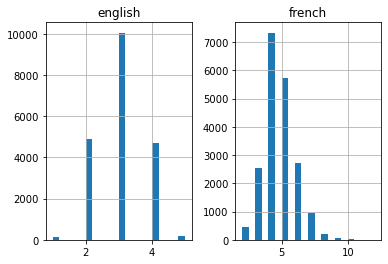

In [5]:
# let’s visualise the length of the sentences.
import pandas as pd

eng_len = []
fren_len = []

# populate the lists with sentence lengths
for i in input_sentences:
      eng_len.append(len(i.split()))  

for i in output_sentences:
      fren_len.append(len(i.split()))

length_df = pd.DataFrame({'english':eng_len, 'french':fren_len})

length_df.hist(bins = 20)
plt.show()

In [6]:
#tokenize the input sentences(input language) 
input_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)


word2idx_inputs = input_tokenizer.word_index
print('Total unique words in the input: %s' % len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

#with open('input_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(input_tokenizer, handle, protocol=4)

Total unique words in the input: 3439
Length of longest sentence in input: 5


In [7]:
#tokenize the output sentences(Output language)
output_tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print('Total unique words in the output: %s' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

#with open('output_tokenizer_NMT.pickle', 'wb') as handle:
#    pickle.dump(output_tokenizer, handle, protocol=4)

Total unique words in the output: 9495
Length of longest sentence in the output: 12


In [8]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[180]:", encoder_input_sequences[180])

encoder_input_sequences.shape: (20000, 5)
encoder_input_sequences[180]: [  0   0   0 303   4]


In [9]:
print(word2idx_inputs["join"])
print(word2idx_inputs["us"])

535
56


In [10]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[180]:", decoder_input_sequences[180])

decoder_input_sequences.shape: (20000, 12)
decoder_input_sequences[180]: [   2 4556   14  127    0    0    0    0    0    0    0    0]


In [11]:
print(word2idx_outputs["<sos>"])
print(word2idx_outputs["joignez-vous"])
print(word2idx_outputs["à"])
print(word2idx_outputs["nous."])

2
2715
19
219


In [12]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)

decoder_output_sequences.shape: (20000, 12)


## WORD EMBEDDINGS

### LINK - https://www.kaggle.com/fullmetal26/glovetwitter27b100dtxt/discussion

#### For English sentences, i.e. the inputs, we will use the GloVe word embeddings. For the translated French sentences in the output, we will use custom word embeddings.

#### Let's create word embeddings for the inputs first. To do so, we need to load the GloVe word vectors into memory. We will then create a dictionary where words are the keys and the corresponding vectors are values,

In [13]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('archive/glove.twitter.27B.200d.txt', encoding="utf8")

for line in glove_file:
    rec = line.split()
    word = rec[0]
    vector_dimensions = asarray(rec[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [14]:
print(embeddings_dictionary["join"])

[-3.7239e-01  4.7634e-01 -1.9666e-01 -1.1641e+00  1.2820e-02 -4.7063e-01
  4.4522e-01  1.8911e-01  5.6740e-01 -6.1915e-02  2.7159e-01 -1.7613e-01
 -5.4897e-01 -1.6782e-01  3.0910e-01  1.0253e-01  4.3412e-01 -4.0300e-02
  3.4782e-02  2.8017e-01  1.6735e-01 -5.3730e-02 -5.9838e-01 -6.7251e-02
 -7.0371e-01  1.0674e+00  4.1123e-01  2.6227e-01 -3.2041e-01  5.2882e-01
  3.6446e-01  1.3661e-01 -2.2680e-01  6.6556e-01  3.4684e-01 -4.1284e-01
  5.5050e-01  3.5691e-01  3.6985e-01 -3.1312e-01  9.2343e-02  1.7105e-01
 -1.5200e-01  6.4297e-02  2.2327e-01  2.9222e-01 -7.3356e-01 -4.6585e-02
 -2.1011e-01  1.2690e-01  3.1638e-01 -5.1846e-01  2.2601e-02 -1.6426e-01
 -8.4231e-02 -6.5978e-02 -1.4436e-01 -2.2150e-01  4.2886e-01  3.0813e-01
 -1.0191e-03  5.9619e-01  1.7514e-01  5.3788e-01 -6.3198e-01  1.5236e-01
 -1.9268e-01  5.8482e-03  6.8425e-01  5.9576e-01  4.4315e-01  3.5061e-01
  1.8628e-01  8.6317e-01  2.1811e-01 -2.6925e-02  1.4113e-01 -6.5218e-03
 -1.8793e-01 -7.6275e-01 -1.9529e-01 -3.8076e-01  2

In [17]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = zeros((num_words, EMBEDDING_SIZE))
for word, index in word2idx_inputs.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [18]:
print(embedding_matrix[464])

[ 4.50590014e-01 -5.43439984e-01 -4.40980010e-02  1.83970004e-01
 -4.18960005e-02 -6.06509984e-01  5.10439992e-01  1.50790006e-01
  3.93849984e-03 -1.22280002e-01 -3.12770009e-02  3.40240006e-03
 -1.09270000e+00  1.72759995e-01  2.84449995e-01 -5.01070023e-01
 -3.68270010e-01 -2.25339994e-01 -1.94419995e-01  2.17519999e-01
  4.35299993e-01  1.41690001e-01  4.60049987e-01 -9.32290018e-01
 -9.34540033e-02  1.09469998e+00 -8.87800008e-03 -4.19609994e-01
  2.54290015e-01  4.13619988e-02  1.91540003e-01 -3.28250006e-02
 -4.45579998e-02  1.93000004e-01 -2.25030005e-01  3.48369986e-01
 -1.54149994e-01  2.65360009e-02 -1.11469999e-01 -8.97450000e-03
  1.81329995e-01 -3.86999995e-01 -9.14589986e-02  2.40260005e-01
 -3.84880006e-01 -5.34229994e-01  4.09379989e-01 -2.55549997e-01
  1.03880003e-01  3.50190014e-01 -9.44890022e-01  2.58309990e-01
  1.26940003e-02 -1.89830009e-02  3.06109995e-01  5.92909992e-01
 -2.33069994e-03  1.20930001e-03  9.30579975e-02  4.28530008e-01
  1.06429998e-02  4.59409

### Creates the embedding layer for the input

In [19]:
embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

## CREATING THE MODEL

In [20]:
decoder_targets_one_hot = np.zeros((
        len(input_sentences),
        max_out_len,
        num_words_output
    ),
    dtype='float32'
)
decoder_targets_one_hot.shape

(20000, 12, 9496)

In [21]:
for i, d in enumerate(decoder_output_sequences):
    for t, word in enumerate(d):
        decoder_targets_one_hot[i, t, word] = 1

In [22]:
encoder_inputs = Input(shape=(max_input_len,))
x = embedding_layer(encoder_inputs)
encoder = LSTM(LSTM_NODES, return_state=True)

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

In [23]:
decoder_inputs = Input(shape=(max_out_len,))

decoder_embedding = Embedding(num_words_output, LSTM_NODES)
decoder_inputs_x = decoder_embedding(decoder_inputs)

decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

In [24]:
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [25]:
#Compile
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 200)       688000      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 12, 256)      2430976     input_2[0][0]                    
______________________________________________________________________________________________

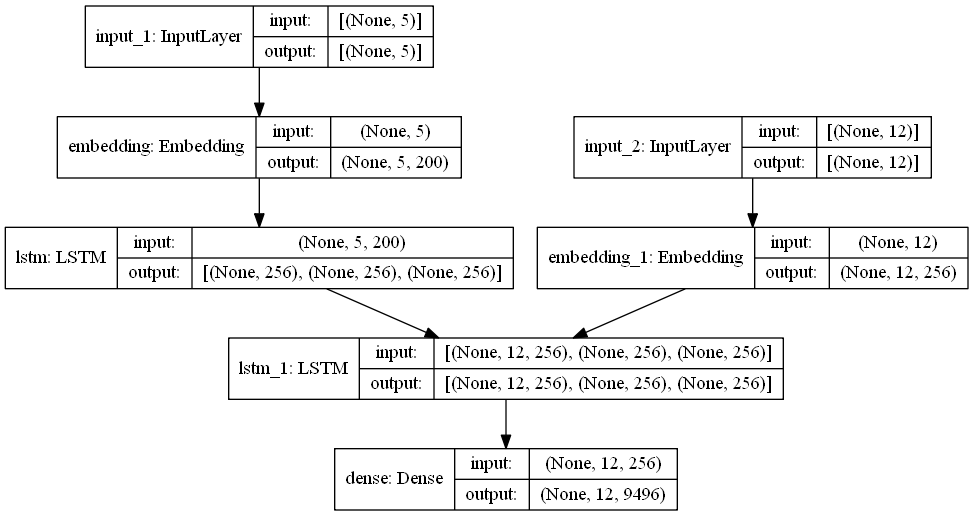

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [28]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [29]:
history = model.fit([encoder_input_sequences, decoder_input_sequences], decoder_targets_one_hot,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[es],
    validation_split=0.1,
)

Epoch 1/20
282/282 [==============================] - 368s 1s/step - loss: 2.7086 - accuracy: 0.6717 - val_loss: 2.0425 - val_accuracy: 0.7098


In [30]:
model.save('seq2seq_eng-fra.h5')

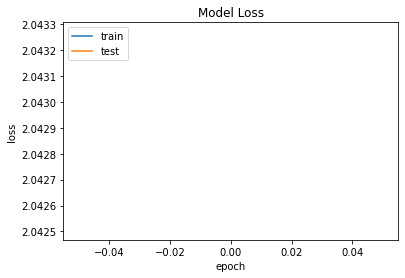

In [31]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
encoder_model = Model(encoder_inputs, encoder_states)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_eng-fra.h5')

In [33]:
decoder_state_input_h = Input(shape=(LSTM_NODES,))
decoder_state_input_c = Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

In [34]:
decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)

In [35]:
decoder_states = [h, c]
decoder_outputs = decoder_dense(decoder_outputs)

In [36]:
decoder_model = Model(
    [decoder_inputs_single] + decoder_states_inputs,
    [decoder_outputs] + decoder_states
)

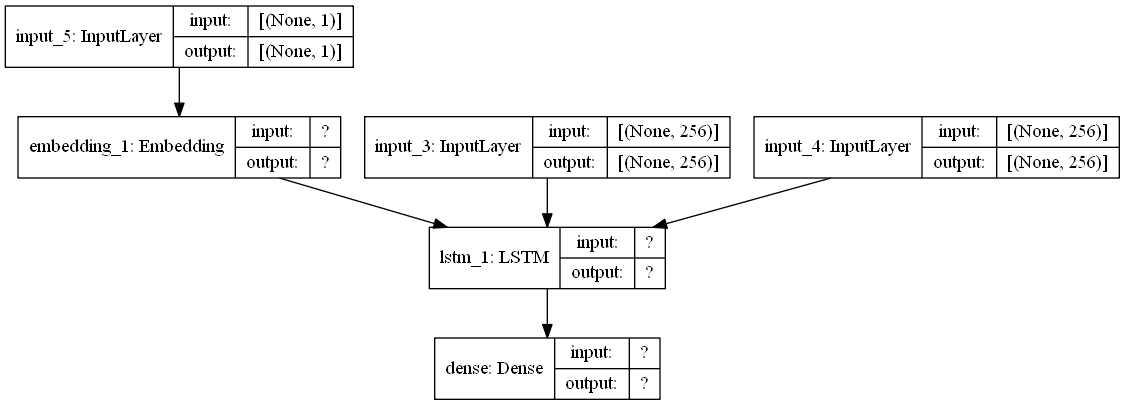

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

## MAKING PREDICTIONS

In [39]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [40]:
def translate_sentence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']
    eos = word2idx_outputs['<eos>']
    output_sentence = []

    for _ in range(max_out_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if eos == idx:
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        target_seq[0, 0] = idx
        states_value = [h, c]

    return ' '.join(output_sentence)

## SAMPLE PREDICTIONS

In [41]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)


Input Language :  Tom'll recover.
Actual translation :  Tom s'en remettra. <eos>
French translation :  c'est sont !


In [42]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

Input Language :  You're so bossy.
Actual translation :  Tu es tellement autoritaire ! <eos>
French translation :  tu êtes pas


In [43]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

Input Language :  It was a miracle.
Actual translation :  C'était un miracle. <eos>
French translation :  c'est est ?


In [44]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

Input Language :  Planning is key.
Actual translation :  La planification est essentielle. <eos>
French translation :  c'est est ?


In [45]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
translation = translate_sentence(input_seq)
print('Input Language : ', input_sentences[i])
print('Actual translation : ', output_sentences[i])
print('French translation : ', translation)

Input Language :  Keep quiet.
Actual translation :  Restez tranquille. <eos>
French translation :  restez !
